# Climate State Finder

The goal of this notebook is to develop a generalized climate state finder. Based on user selected variable and event definitions, this notebook will search all simulations to find these climate states. Inputs:

* Domain,a custom shapefile
* One variable
* GWL

## Make Selections

Before running this notebook, make the following selections for variables, domain, and GWLs.

1. Select a timescale - this will impact which downscaling methods are available and which variables are availble.

In [2]:
timescale = "monthly" # options are hourly, daily or monthly

2. Select a variable - the code below displays which variables are available based on your timescale options

In [3]:
# import function 
from climakitae.explore.agnostic import (
  show_available_vars
)

In [4]:
# display variables available for this analysis 
# only showing dynamical because statistical has a smaller subset that is in the larger dynamical subset
# only difference is max/min RH is availble in statistical and not in dynamical 
show_available_vars("Dynamical",timescale)

Future exception was never retrieved
future: <Future finished exception=ClientConnectionError('Connection lost: [SSL: APPLICATION_DATA_AFTER_CLOSE_NOTIFY] application data after close notify (_ssl.c:2706)')>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.12/asyncio/sslproto.py", line 651, in _do_shutdown
    self._sslobj.unwrap()
  File "/srv/conda/envs/notebook/lib/python3.12/ssl.py", line 920, in unwrap
    return self._sslobj.shutdown()
           ^^^^^^^^^^^^^^^^^^^^^^^
ssl.SSLError: [SSL: APPLICATION_DATA_AFTER_CLOSE_NOTIFY] application data after close notify (_ssl.c:2706)

The above exception was the direct cause of the following exception:

aiohttp.client_exceptions.ClientConnectionError: Connection lost: [SSL: APPLICATION_DATA_AFTER_CLOSE_NOTIFY] application data after close notify (_ssl.c:2706)


['Air Temperature at 2m',
 'Precipitation (total)',
 'Relative humidity',
 'Dew point temperature',
 'Mean wind speed at 10m',
 'Maximum wind speed at 10m',
 'Surface Pressure',
 'Specific humidity at 2m',
 'Surface skin temperature',
 'Maximum air temperature at 2m',
 'Minimum air temperature at 2m',
 'Instantaneous downwelling longwave flux at bottom',
 'Instantaneous downwelling shortwave flux at bottom',
 'Shortwave flux at the surface',
 'Longwave flux at the surface',
 'Sensible heat flux at the surface',
 'Latent heat flux at the surface',
 'Ground heat flux',
 'Snowfall',
 'Liquid water path',
 'Evaporation',
 'Ice water path',
 'Maximum precipitation']

Future exception was never retrieved
future: <Future finished exception=ClientConnectionError('Connection lost: [SSL: APPLICATION_DATA_AFTER_CLOSE_NOTIFY] application data after close notify (_ssl.c:2706)')>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.12/asyncio/sslproto.py", line 651, in _do_shutdown
    self._sslobj.unwrap()
  File "/srv/conda/envs/notebook/lib/python3.12/ssl.py", line 920, in unwrap
    return self._sslobj.shutdown()
           ^^^^^^^^^^^^^^^^^^^^^^^
ssl.SSLError: [SSL: APPLICATION_DATA_AFTER_CLOSE_NOTIFY] application data after close notify (_ssl.c:2706)

The above exception was the direct cause of the following exception:

aiohttp.client_exceptions.ClientConnectionError: Connection lost: [SSL: APPLICATION_DATA_AFTER_CLOSE_NOTIFY] application data after close notify (_ssl.c:2706)
Future exception was never retrieved
future: <Future finished exception=ClientConnectionError('Connection lost: [SSL: APPLICATION_DATA_AFTER_CLOSE_NOTI

In [5]:
# make selection from list above
event_variable = "Air Temperature at 2m"

3. Select a baseline and future GWL

In [6]:
# current options 0.8, 1.0, 1.2, 1.5, 2.0, 2.5, 3.0, 4.0
baseline_gwl = "0.8"
future_gwl = "2.0"

4. Select Spatial Domain - provide a shapefile to clip data to

In [10]:
# edit path below and filename for shapefile to use
shapefile_filename = 'PajaroRiverWatershed.zip'
spatial_domian = "Pajaro" # name will appear in title

5. Select Resolution - select the the model resolution (3km, 9km, 45 km)

In [11]:
resolution = "3 km"

6. Aggregation Method - select a method to aggregate spatially and temporally (to monthly values)

In [12]:
aggregation = "mean" # options are mean, median, sum

7. Climate State Duration - how often should the climate state be observed to be considered a 'hit' 

In [71]:
# duration (in months)
duration = 6 

## Import libraries & define functions

In [13]:
import climakitae as ck 
from climakitae.core.data_interface import (
    get_data_options, 
    get_subsetting_options, 
    get_data
)
from climakitae.util.utils import add_dummy_time_to_wl

import xarray as xr
import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [14]:
def clip_to_shapefile(da, shapefile):
    """
    Clip a DataArray to the boundaries of a shapefile.

    Parameters:
    - da: xarray DataArray to be clipped
    - shapefile: path to the shapefile

    Returns:
    - Clipped DataArray
    """
    # Read the shapefile using geopandas
    gdf = gpd.read_file(shapefile)

    # Ensure the DataArray has a CRS set
    #da.rio.write_crs("epsg:2228", inplace=True)

    # Clip the DataArray using the shapefile geometry
    clipped_da = da.rio.clip(gdf.geometry.apply(mapping), gdf.crs, drop=True)

    return clipped_da

## Pull Data

### Dynamical Downscaling (wrf)

In [15]:
# WRF downscaling
wrf_data =get_data(
        variable = event_variable, 
        downscaling_method = "Dynamical", 
        resolution = resolution, 
        timescale = timescale, 
        # Modify your approach 
        approach = "Warming Level",
        warming_level= [float(baseline_gwl), float(future_gwl)],
    )

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
! Returned data array is large. Operations could take up to 5x longer than 1GB of data!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

WARNING FOR WARMING LEVELS APPROACH
-----------------------------------
There may be NaNs in your data for certain simulation/warming level combinations if the warming level is not reached for that particular simulation before the year 2100. 

This does not mean you have missing data, but rather a feature of how the data is combined in retrieval to return a single data object. 

If you want to remove these empty simulations, it is recommended to first subset the data object by each individual warming level and then dropping NaN values.


In [16]:
# rename lat lon
wrf_data=wrf_data.rename({'x': 'longitude','y': 'latitude'})

In [17]:
# add a dummy time variable
wrf_data = add_dummy_time_to_wl(wrf_data)

### Statistical Downscaling (loca2)

In [18]:
# grab correct variable name for loca 2 
loca_variable = [event_variable]
# temperature
if loca_variable[0] == "Air Temperature at 2m":
    loca_variable = ["Maximum air temperature at 2m", "Minimum air temperature at 2m"]
# relative humidity
if loca_variable[0] == "Relative humidity":
    loca_variable = ["Minimum relative humidity", "Maximum relative humidity"]

In [19]:
# statistical - loca2 downscaling xvariable
loca_data = [get_data(
        variable = GETVAR, 
        downscaling_method = "Statistical", 
        resolution = resolution, 
        timescale = timescale, 
        # Modify your approach 
        approach = "Warming Level",
        warming_level= [float(baseline_gwl),float(future_gwl)],
    ) for GETVAR in loca_variable]

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Returned data array is huge. Operations could take 10x to infinity longer than 1GB of data !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

WARNING FOR WARMING LEVELS APPROACH
-----------------------------------
There may be NaNs in your data for certain simulation/warming level combinations if the warming level is not reached for that particular simulation before the year 2100. 

This does not mean you have missing data, but rather a feature of how the data is combined in retrieval to return a single data object. 

If you want to remove these empty simulations, it is recommended to first subset the data object by each individual warming level and then dropping NaN values.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Returned data array is huge. Operations could take 10x to

In [20]:
# if we need to average 
if loca_data[0] is not None:
    # temperature
    if event_variable == "Air Temperature at 2m":
        loca_data = (loca_data[0] + loca_data[1]) / 2
        loca_data.name = "Air Temperature at 2m"
        
    # relative humidity
    if event_variable == "Relative humidity":
        loca_data = (loca_data[0] + loca_data[1]) / 2
        loca_data.name = "Relative humidity"

In [21]:
# unlist if needed
if type(loca_data) == list:
    loca_data = loca_data[0]

# now merge
# first check if there is valid loca data - requires that both x and y have valid data
if loca_data is None:
    # set to wrf
    loca_data = wrf_data
    # replace with all NaNs
    loca_data = loca_data*np.nan
else:
    loca_data=loca_data.rename({'lon': 'longitude','lat': 'latitude'})

In [22]:
# add a dummy time variable
loca_data = add_dummy_time_to_wl(loca_data)

## Prepare Data

In [23]:
# clip to shapefile
wrf_data = clip_to_shapefile(wrf_data, shapefile_filename)
loca_data = clip_to_shapefile(loca_data, shapefile_filename)

In [24]:
# create monthly aggegations
if timescale != "monthly":
    wrf_data = eval(f"wrf_data.resample(time = '1M').{aggregation}()")
    loca_data = eval(f"loca_data.resample(time = '1M').{aggregation}()")

In [25]:
# average across domain (we want single timeseries)
wrf_data = eval(f"wrf_data.{aggregation}(['longitude','latitude'])")
loca_data = eval(f"loca_data.{aggregation}(['longitude','latitude'])")

## Import Data

In [26]:
loca_data = loca_data.compute()
wrf_data = wrf_data.compute()

## Calculate Anomaly 

### Calculate climatologlical mean of baseline gwl

In [27]:
# calculate monthly mean for each simulation for the baseline gwl
loca_clim_mean = loca_data.sel(warming_level = float(baseline_gwl)).groupby("time.month").median()
wrf_clim_mean = wrf_data.sel(warming_level = float(baseline_gwl)).groupby("time.month").median()

### Calculate anomaly of future gwl to climatologlical mean

In [48]:
# subtract the monthly climatology from the future gwl data to create an anomaly
loca_anom = loca_data.sel(warming_level = float(future_gwl)).groupby("time.month") - loca_clim_mean
wrf_anom = wrf_data.sel(warming_level = float(future_gwl)).groupby("time.month") - wrf_clim_mean

### Calculate Seasonal Rolling Average 

In [61]:
loca_anom = loca_anom.rolling(time=4).median()
wrf_anom = wrf_anom.rolling(time=4).median()

## Define Climate States 

In [73]:
# calculate historical anomaly
hist_loca_anom = loca_data.sel(warming_level = float(baseline_gwl)).groupby("time.month") - loca_clim_mean
hist_wrf_anom = wrf_data.sel(warming_level = float(baseline_gwl)).groupby("time.month") - wrf_clim_mean

In [74]:
# caclualte the seasonal rolling average
hist_loca_anom = hist_loca_anom.rolling(time=4).median()
hist_wrf_anom = hist_wrf_anom.rolling(time=4).median()

In [76]:
# calculate the standard deviation of the historical anomaly to use a threshold
locaStd = hist_loca_anom.std(dim="time")
wrfStd = hist_wrf_anom.std(dim="time")

In [77]:
# add to data array
wrf_anom = wrf_anom.assign_coords(climate_state = ("simulation",wrfStd.values))
loca_anom = loca_anom.assign_coords(climate_state = ("simulation",locaStd.values))

In [ ]:
# create a 'hit' for in climate state


## Prep for Plotting

In [78]:
# create a 'model' variable
lsims=loca_anom.simulation.values.tolist()
loca_models = [s.split("_")[1] for s in lsims]
loca_anom = loca_anom.assign_coords(models = ("simulation",loca_models))

In [79]:
wsims=wrf_anom.simulation.values.tolist()
wrf_models = [s.split("_")[1] for s in wsims]
wrf_anom = wrf_anom.assign_coords(models = ("simulation",wrf_models))

In [80]:
# create a relization variable
loca_realization = [s.split("_")[2]+'_'+s.split("_")[3] for s in lsims]
loca_anom = loca_anom.assign_coords(relization = ("simulation",loca_realization))
wrf_realization = [s.split("_")[2]+'_'+s.split("_")[3] for s in wsims]
wrf_anom = wrf_anom.assign_coords(relization = ("simulation",wrf_realization))

In [81]:
# create a data frame to make plotting easier
locaDF = loca_anom.to_dataframe().reset_index()
wrfDF = wrf_anom.to_dataframe().reset_index()

In [82]:
# Create a downscaling name
locaDF["downscaling"] = "loca2"
wrfDF["downscaling"] = "wrf"

In [83]:
# combine into one 
finalDF = pd.concat([locaDF, wrfDF],keys=locaDF.keys())

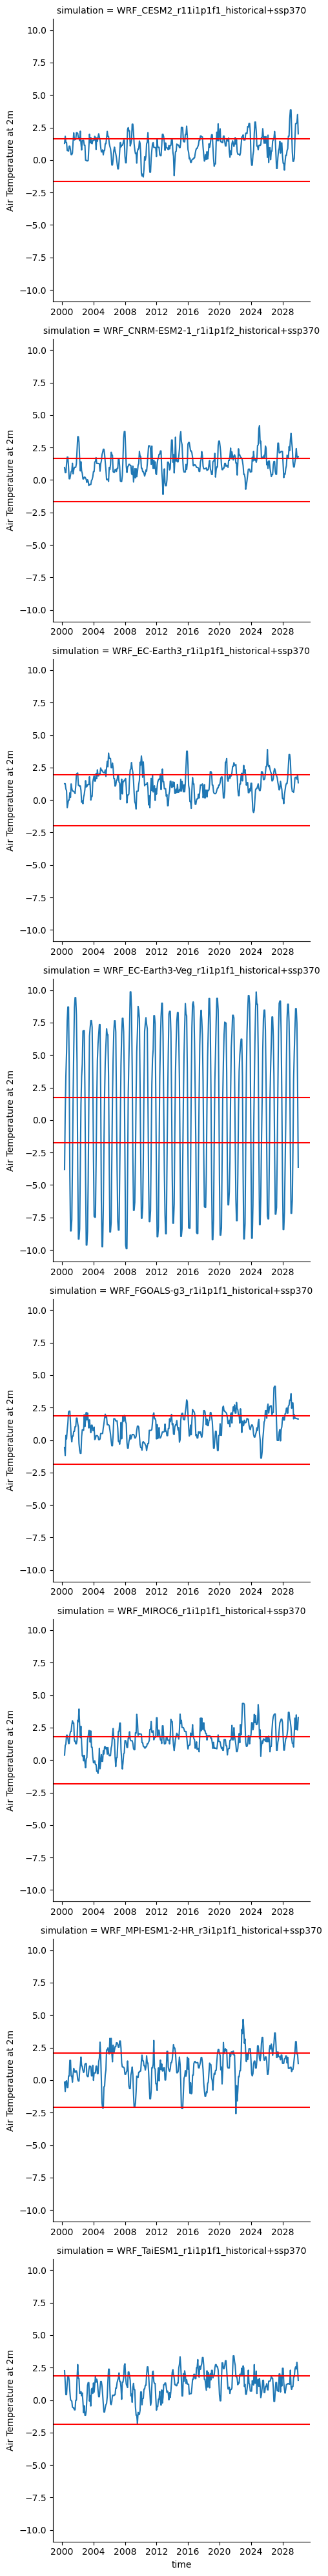

In [86]:
# plot example of WRF
def annotate(data, **kws):
    n = 2*data.climate_state.mean()
    ax = plt.gca()
    ax.axhline(y=n, color="red")
    ax.axhline(y=-n, color="red")
g1 = sns.relplot(
    data=wrfDF,
    x="time", y="Air Temperature at 2m",
    row="simulation",
    kind="line", ci=None,
    height=5, aspect=1, facet_kws=dict(sharex=False), 
)
g1.map_dataframe(annotate)

## Plot Yay!

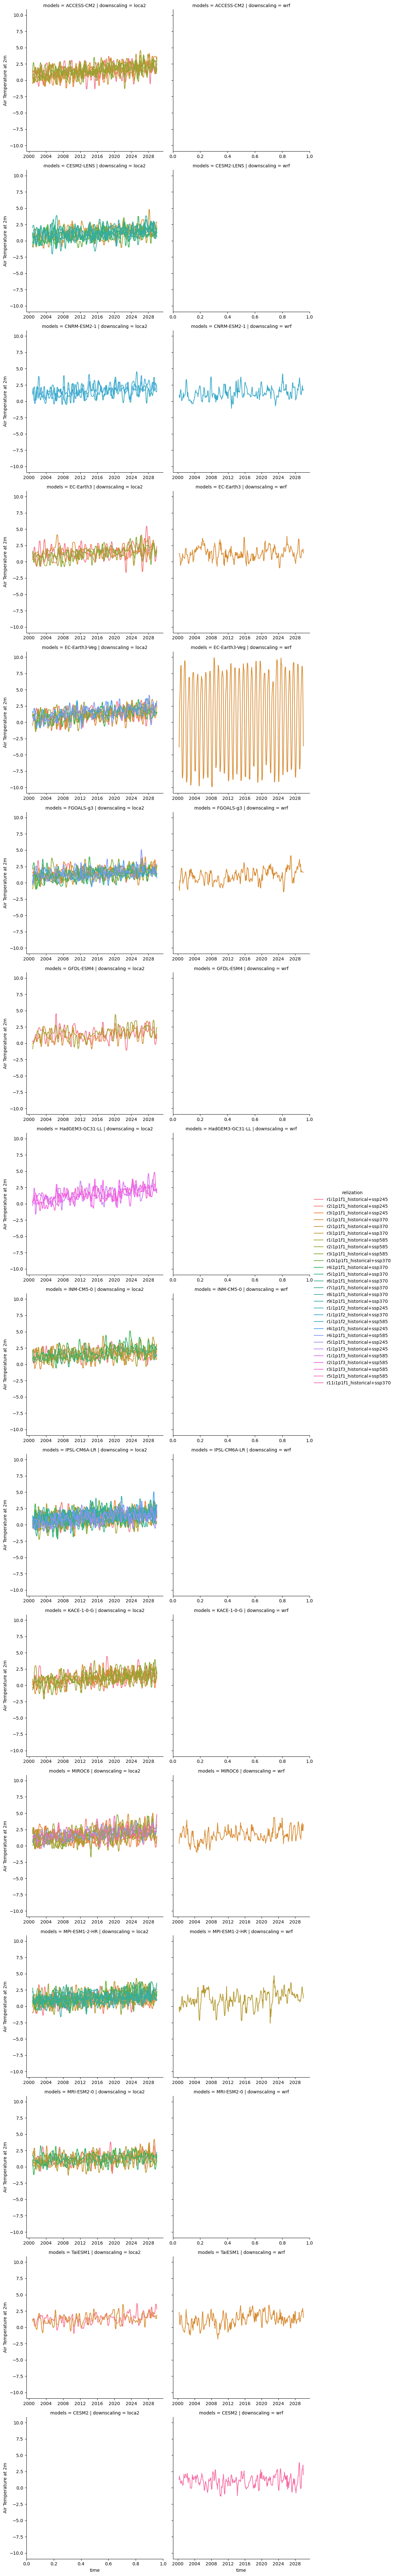

In [70]:
def annotate(data, **kws):
    n = 2*data.climate_state
    ax = plt.gca()
    ax.axhline(y=n, color="relization")
    ax.axhline(y=-n, color="relization")
g1 = sns.relplot(
    data=finalDF,
    x="time", y="Air Temperature at 2m",
    hue = "relization",
    col="downscaling",row="models",
    kind="line", ci=None,
    height=5, aspect=1, facet_kws=dict(sharex=False), 
)
#g1.map_dataframe(annotate)